**Project Introduction**

In this project, I have focused on doing a comprehensive analysis of user journeys on the 365 Data Science platform to identify key pathways that drive user subscriptions.

**Project Objectives:**

Analyze and interpret sequences of page visits to uncover the most impactful user pathways.
Identify potential drop-off points or unnecessary pages that may hinder a seamless user experience.
Utilize Python to create custom tools and functions for an in-depth journey analysis, applying systematic approaches to parse and interpret user behavior data.

**Step 1: Importing Libraries and Data Exploration**

In [33]:
#importing the required libraries
"""
numpy: various mathematical operations
pandas: perform tasks as data cleaning, exploring etc.
matplotlib: data visualizationss such as plot graphs.
%matplotlib inline : informs matplotlib to directly plot the graphs below code cells
seaborn: more interactive visualizations
warnings: avoid unnecessary warnings
"""

import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [34]:
#loading the data
user_data=pd.read_csv('user_journey_raw.csv')

In [35]:
class color:
   BLUE = '\033[94m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(color.BOLD + color.BLUE+'User Journey DataFrame' + color.END+"\n")
print('Number of rows:',user_data.shape[0])
print('Number of columns:',user_data.shape[1] )

User Journey DataFrame

Number of rows: 9935
Number of columns: 4


In [36]:
#doing the basic sanity checks
user_data.head()

user_id  session_id subscription_type  \
0     1516     2980231            Annual   
1     1516     2980248            Annual   
2     1516     2992252            Annual   
3     1516     3070491            Annual   
4     1516     3709807            Annual   

                                        user_journey  
0  Homepage-Log in-Log in-Log in-Log in-Log in-Lo...  
1  Other-Sign up-Sign up-Sign up-Sign up-Sign up-...  
2          Log in-Log in-Log in-Log in-Log in-Log in  
3  Homepage-Log in-Log in-Log in-Log in-Log in-Lo...  
4  Log in-Log in-Log in-Log in-Log in-Log in-Log ...

In [37]:
#type of data we are dealing with
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9935 entries, 0 to 9934
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            9935 non-null   int64 
 1   session_id         9935 non-null   int64 
 2   subscription_type  9935 non-null   object
 3   user_journey       9935 non-null   object
dtypes: int64(2), object(2)
memory usage: 310.6+ KB


In [38]:
#How does statistics look like for columns

user_data.describe()

user_id    session_id
count    9935.000000  9.935000e+03
mean   401709.580775  3.464916e+06
std    106934.401794  1.095088e+06
min      1516.000000  1.817000e+03
25%    335237.000000  3.087452e+06
50%    461458.000000  3.640994e+06
75%    470347.000000  4.247818e+06
max    509096.000000  4.845427e+06

In [39]:
#checking the number of null entries present in the data
user_data.isnull().sum()

user_id              0
session_id           0
subscription_type    0
user_journey         0
dtype: int64

**So we have no-null entries present in the data.**

# **Step 2: Data Manipulation and Pre-processing**

The raw data which is present as part of this csv file before doing the data analysis we can try to make it a little cleaner. Example: We can try to remove the entries that are occuring consecutively, remove the multiple entries if present again same users.

In [40]:
#checking the columns
user_data['user_journey'].value_counts()

user_journey
Log in-Log in                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        1337
Other-Other                                                                                                                                                                                                                                                                                                                                                                                                                                                              

**In the below transition matrix, the focus is to visualize the likelihood of transitions between different pages, giving insights into common paths.**

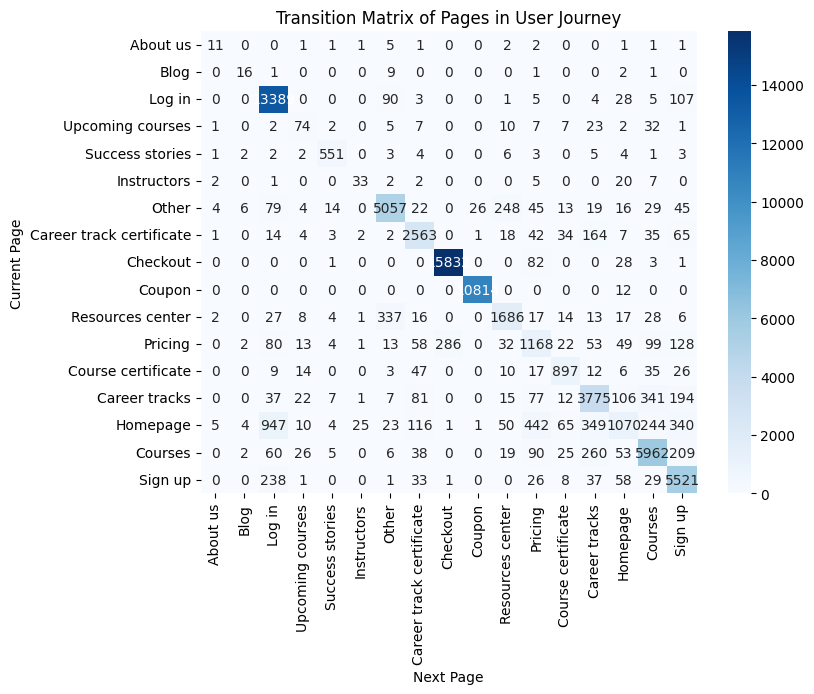

In [41]:
# Create a transition matrix
pages = list(set([page for journey in user_data['user_journey'] for page in journey.split('-')]))
transition_matrix = pd.DataFrame(0, index=pages, columns=pages)

# Populate the transition matrix
for journey in user_data['user_journey']:
    pages_in_journey = journey.split('-')
    for i in range(len(pages_in_journey) - 1):
        transition_matrix.loc[pages_in_journey[i], pages_in_journey[i + 1]] += 1

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, cmap="Blues", fmt="d")
plt.title("Transition Matrix of Pages in User Journey")
plt.xlabel("Next Page")
plt.ylabel("Current Page")
plt.show()

In [42]:
#checking the first few columns of the user_journey column
user_data['user_journey'].head()

0    Homepage-Log in-Log in-Log in-Log in-Log in-Lo...
1    Other-Sign up-Sign up-Sign up-Sign up-Sign up-...
2            Log in-Log in-Log in-Log in-Log in-Log in
3    Homepage-Log in-Log in-Log in-Log in-Log in-Lo...
4    Log in-Log in-Log in-Log in-Log in-Log in-Log ...
Name: user_journey, dtype: object

### **Step 2.1**

Since we that that many pages in the user journey column may have repeating pages. So in order to have a better analysis we can remove the duplicate sequence pages and only keeps those entries which are leading to subscription.

In [43]:
# defining function to remove the duplicate pages
def remove_duplicate_pages(user_data, desired_column):

    # define function to process the string in each column
    def string_clean(page_seq):
        # split each string at the hyphen
        pages = page_seq.split('-')
        # create empty list to store the new string
        new_seq = []
        prev_page = None

        # iterate through the string to find + remove consecutive pages
        for page in pages:
            if page != prev_page:
                new_seq.append(page)
                prev_page = page

        return '-'.join(new_seq)
    new_df = user_data.copy()

    # apply string_clean to the entire df
    new_df[desired_column] = new_df[desired_column].apply(string_clean)

    return new_df

### **Step 2.2**

For same users we might have multiple sessions. In the below step we can also consolidate the sessions IDs available for each user into one user_id.

In [44]:
# create a function to consolidate same user_id data into one row
def group_users(user_data, group_name = 'user_id', target_column = 'user_journey', sessions = 'All', count_from = 'first',secondary_group='subscription_type',):
    # make a copy of df to not alter the original
    grouped_df = user_data.copy()

    # group data based on sessions specified by user
    if sessions != 'All':
        if count_from == 'first':
            grouped_df = grouped_df.groupby(group_name).head(sessions)
        elif count_from == 'last':
            grouped_df = grouped_df.groupby(group_name).tail(sessions)

    # create one string for user_journer from specified sessions
    grouped_df = grouped_df.groupby([group_name, secondary_group], as_index=False)[target_column].agg(lambda x:'-'.join(x))

    return grouped_df

In [45]:
#checking the users after grouping
grouped_users=group_users(user_data)
grouped_users

user_id subscription_type  \
0        1516            Annual   
1        3395            Annual   
2       10107            Annual   
3       11145           Monthly   
4       12400           Monthly   
5       13082           Monthly   
6       14415           Monthly   
7       15630            Annual   
8       16589         Quarterly   
9       19458            Annual   
10      20355           Monthly   
11      22679            Annual   
12      23292            Annual   
13      24414            Annual   
14      31705            Annual   
15      34689           Monthly   
16      34912            Annual   
17      37614            Annual   
18      37828            Annual   
19      39452            Annual   
20      41200            Annual   
21      49669            Annual   
22      60084           Monthly   
23      71559            Annual   
24      72771           Monthly   
25      74256            Annual   
26      75048            Annual   
27      82563           Monthly   
28      88208            Annual   
29      96793            Annual   
30      97516            Annual   
31     102461            Annual   
32     105172            Annual   
33     105951            Annual   
34     108970            Annual   
35     110519            Annual   
36     120485           Monthly   
37     121047            Annual   
38     125167            Annual   
39     126202            Annual   
40     135366            Annual   
41     142012           Monthly   
42     143885            Annual   
43     148246            Annual   
44     150335            Annual   
45     150418            Annual   
46     151003         Quarterly   
47     152002            Annual   
48     152882           Monthly   
49     153570            Annual   
50     156771            Annual   
51     156880           Monthly   
52     157143            Annual   
53     158113           Monthly   
54     160910            Annual   
55     161329            Annual   
56     161523           Monthly   
57     161548            Annual   
58     162545           Monthly   
59     171697            Annual   
60     172645            Annual   
61     182313            Annual   
62     185224            Annual   
63     185236            Annual   
64     185890            Annual   
65     188451            Annual   
66     191962            Annual   
67     195227            Annual   
68     202020            Annual   
69     203365            Annual   
70     204731            Annual   
71     209680            Annual   
72     212532            Annual   
73     217381            Annual   
74     219706           Monthly   
75     220511            Annual   
76     220744            Annual   
77     222389            Annual   
78     223121           Monthly   
79     223597           Monthly   
80     223721            Annual   
81     223777           Monthly   
82     223883            Annual   
83     226950            Annual   
84     227784            Annual   
85     227846            Annual   
86     228059            Annual   
87     229602            Annual   
88     230961            Annual   
89     233544            Annual   
90     235712            Annual   
91     236893         Quarterly   
92     237247            Annual   
93     244110            Annual   
94     244693            Annual   
95     247070            Annual   
96     248835            Annual   
97     249736            Annual   
98     250430            Annual   
99     253512            Annual   
100    255892            Annual   
101    256301           Monthly   
102    256312            Annual   
103    258989           Monthly   
104    260579           Monthly   
105    261077            Annual   
106    261624            Annual   
107    262246           Monthly   
108    262728            Annual   
109    262999            Annual   
110    263101            Annual   
111    266371            Annual   
112    267025            Annual   
113    267334   

In [46]:
#calling the function to remove duplicate instances
cleaned_data=remove_duplicate_pages(grouped_users,'user_journey')

In [47]:
#checking the cleaned data
cleaned_data.head()

user_id subscription_type  \
0     1516            Annual   
1     3395            Annual   
2    10107            Annual   
3    11145           Monthly   
4    12400           Monthly   

                                        user_journey  
0  Homepage-Log in-Other-Sign up-Log in-Homepage-...  
1  Other-Pricing-Sign up-Log in-Homepage-Pricing-...  
2  Homepage-Career tracks-Homepage-Career tracks-...  
3  Homepage-Log in-Homepage-Log in-Homepage-Log i...  
4  Homepage-Career tracks-Sign up-Log in-Other-Ca...

### **Step 2.3:**

There might also be unessential page visits by a customer where they are just exploring the website however the core of this project is to emphasize on those users that eventually buy a subscription. So we can remove those unessential page visits

In [48]:
# create a function that removes unessential page visits
def remove_pages(user_data, pages_list, target_column = 'user_journey'):
    # make copy of df
    new_df = user_data.copy()

    # create function to check page visits for each row and remove them if they are in the list provided
    def check_pages(all_pages):
        # split each page in the string for each row
        pages = all_pages.split('-')
        # create an empty list to store pages that are not in the specified list
        new_pages = []

        # add words to new_pages that are not in the specified list
        for page in pages:
            if page not in pages_list:
                new_pages.append(page)
        # join the pages into one string seperated by a hyphen
        return '-'.join(new_pages)

    # apply check_pages funtion to entire target column
    new_df[target_column] = new_df[target_column].apply(check_pages)

    return new_df

In [49]:
#storing the other category where nothing was happening
unessential_pages=['Other']

#running this across our cleaned data
cleaned_data=remove_pages(cleaned_data,unessential_pages)

In [50]:
#checking the data now
cleaned_data

user_id subscription_type  \
0        1516            Annual   
1        3395            Annual   
2       10107            Annual   
3       11145           Monthly   
4       12400           Monthly   
5       13082           Monthly   
6       14415           Monthly   
7       15630            Annual   
8       16589         Quarterly   
9       19458            Annual   
10      20355           Monthly   
11      22679            Annual   
12      23292            Annual   
13      24414            Annual   
14      31705            Annual   
15      34689           Monthly   
16      34912            Annual   
17      37614            Annual   
18      37828            Annual   
19      39452            Annual   
20      41200            Annual   
21      49669            Annual   
22      60084           Monthly   
23      71559            Annual   
24      72771           Monthly   
25      74256            Annual   
26      75048            Annual   
27      82563           Monthly   
28      88208            Annual   
29      96793            Annual   
30      97516            Annual   
31     102461            Annual   
32     105172            Annual   
33     105951            Annual   
34     108970            Annual   
35     110519            Annual   
36     120485           Monthly   
37     121047            Annual   
38     125167            Annual   
39     126202            Annual   
40     135366            Annual   
41     142012           Monthly   
42     143885            Annual   
43     148246            Annual   
44     150335            Annual   
45     150418            Annual   
46     151003         Quarterly   
47     152002            Annual   
48     152882           Monthly   
49     153570            Annual   
50     156771            Annual   
51     156880           Monthly   
52     157143            Annual   
53     158113           Monthly   
54     160910            Annual   
55     161329            Annual   
56     161523           Monthly   
57     161548            Annual   
58     162545           Monthly   
59     171697            Annual   
60     172645            Annual   
61     182313            Annual   
62     185224            Annual   
63     185236            Annual   
64     185890            Annual   
65     188451            Annual   
66     191962            Annual   
67     195227            Annual   
68     202020            Annual   
69     203365            Annual   
70     204731            Annual   
71     209680            Annual   
72     212532            Annual   
73     217381            Annual   
74     219706           Monthly   
75     220511            Annual   
76     220744            Annual   
77     222389            Annual   
78     223121           Monthly   
79     223597           Monthly   
80     223721            Annual   
81     223777           Monthly   
82     223883            Annual   
83     226950            Annual   
84     227784            Annual   
85     227846            Annual   
86     228059            Annual   
87     229602            Annual   
88     230961            Annual   
89     233544            Annual   
90     235712            Annual   
91     236893         Quarterly   
92     237247            Annual   
93     244110            Annual   
94     244693            Annual   
95     247070            Annual   
96     248835            Annual   
97     249736            Annual   
98     250430            Annual   
99     253512            Annual   
100    255892            Annual   
101    256301           Monthly   
102    256312            Annual   
103    258989           Monthly   
104    260579           Monthly   
105    261077            Annual   
106    261624            Annual   
107    262246           Monthly   
108    262728            Annual   
109    262999            Annual   
110    263101            Annual   
111    266371            Annual   
112    267025            Annual   
113    267334   

In [51]:
#since we have done few preprocessing tasks exporting the cleaned data to a new file for further analysis
cleaned_data.to_csv(r'clean_data.csv',index=False)

**Step 3: User Behavior Journey Analysis on Cleaned data**

Now we will use the file that we got as part of cleaning steps and work on that to understand the user behavior and understand some logistics.

In [52]:
#importing the cleaned data
cleaned_data=pd.read_csv('clean_data.csv')

In [53]:
#checking for missing values once again
cleaned_data.isnull().sum()

user_id               0
subscription_type     0
user_journey         88
dtype: int64

**We have around 88 missing entries. Since this is a small portion of data removing them from user journey column**

In [55]:
#removing the null entries
cleaned_data=cleaned_data.dropna()

In [56]:
#checking the null values again
cleaned_data.isnull().sum()

user_id              0
subscription_type    0
user_journey         0
dtype: int64

**Now we have dealt with all the missing values**

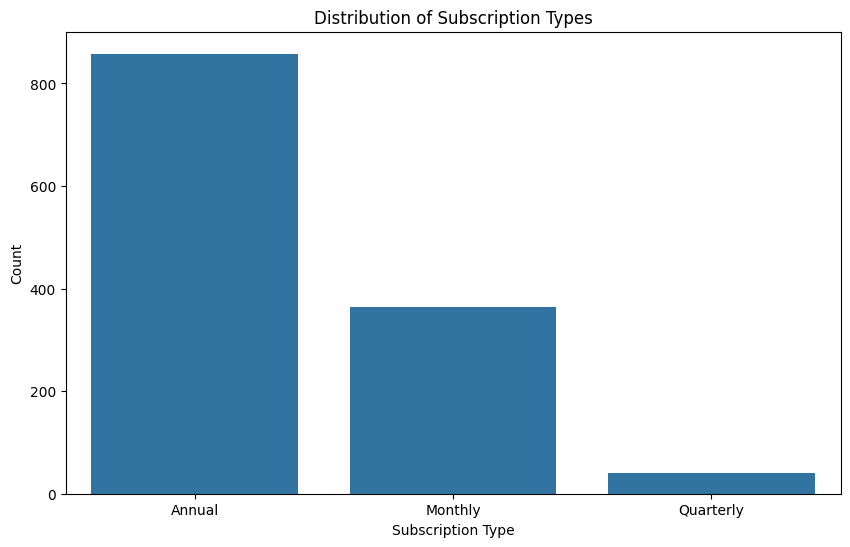

In [57]:
#plotting a graph once again to visualize the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='subscription_type', data=cleaned_data)
plt.title('Distribution of Subscription Types')
plt.xlabel('Subscription Type')
plt.ylabel('Count')
plt.show()

**So we see that customers who have high chances of conversion are the ones who go for annual subscription. One potential reasoning for this could be that annual subscription plans offers low-cost than monthly or quarterly. So in future 365 data science company can continue doing this.**

In [63]:
# define a function that counts how times a page can be found in all user journeys

def page_count(df, subtype = 'All', target_column = 'user_journey'):
    df_copy = df.copy()
    # drop missing values
    df_copy = df_copy.dropna()

    # choose membership type
    if subtype != 'All':
        df_copy = df_copy[df_copy['subscription_type'].str.contains(subtype)]


    # split the pages at the hyphen
    pages_list = df_copy[target_column].str.split('-')
    # flatten the rows of list
    pages = [page for sublist in pages_list for page in sublist]
    # create a series to count the values
    pages_count = pd.Series(pages).value_counts()



    return pages_count

In [64]:
#checking the page count
page_count(cleaned_data,'Quarterly')

Homepage                    109
Log in                       94
Sign up                      65
Checkout                     63
Career tracks                36
Courses                      36
Pricing                      33
Career track certificate     18
Course certificate           10
Coupon                        8
Resources center              8
Success stories               4
Upcoming courses              2
About us                      1
Name: count, dtype: int64

In [58]:
# define a function that counts if a page is found in user's journeys

def page_presence(df, subtype = 'All', target_column = 'user_journey'):
    df_copy = df.copy()
    # drop missing values
    df_copy = df_copy.dropna()

    # choose membership type
    if subtype != 'All':
        df_copy = df_copy[df_copy['subscription_type'].str.contains(subtype)]

    # split the pages at the hyphen
    pages_list = df_copy[target_column].str.split('-')

    # convert each list to a set to remove duplicates
    pages_list = pages_list.apply(lambda x: list(set(x)) if isinstance(x, list) else x)

    # flatten the rows of list
    pages = [page for sublist in pages_list for page in sublist]

    # create a series to count the values
    pages_count = pd.Series(pages).value_counts()


    return pages_count

In [65]:
#checking the quarterly page presence
quarterly_pages=page_presence(cleaned_data,'Quarterly')
quarterly_pages

Checkout                    38
Sign up                     36
Homepage                    32
Log in                      32
Pricing                     16
Courses                     15
Career tracks               13
Career track certificate     8
Course certificate           7
Coupon                       6
Resources center             4
Success stories              2
Upcoming courses             2
About us                     1
Name: count, dtype: int64

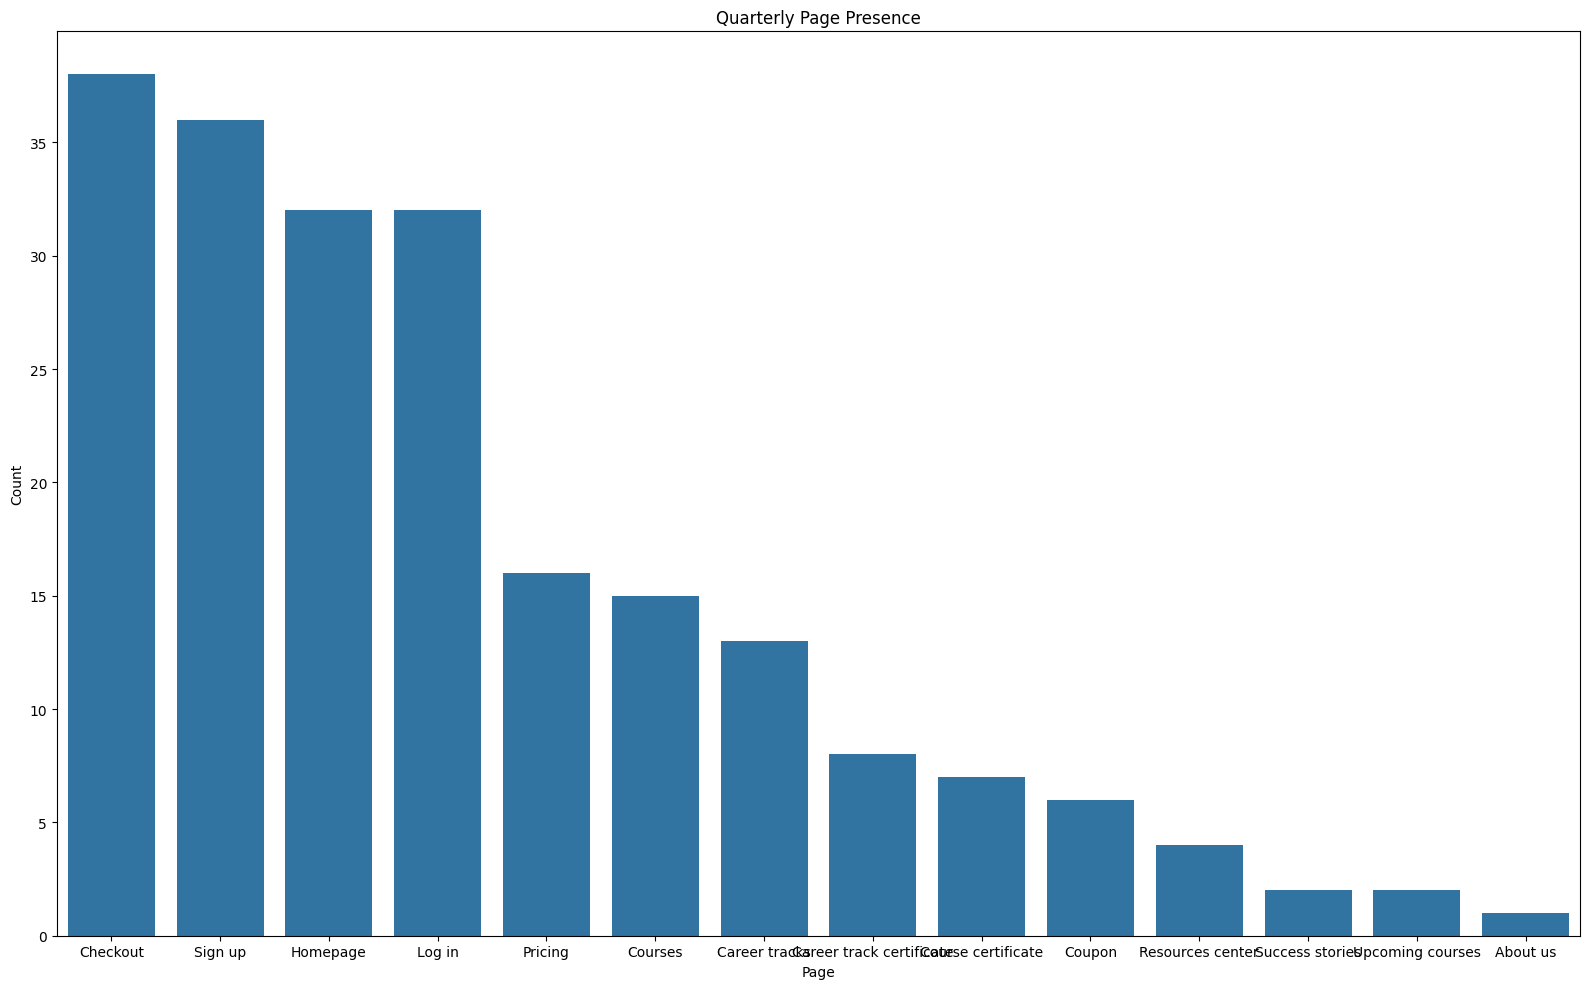

In [74]:
#visualizing the distribution
plt.figure(figsize=(16,10))
sns.barplot(x=quarterly_pages.index, y=quarterly_pages.values)
plt.title('Quarterly Page Presence')
plt.xlabel('Page')
plt.ylabel('Count')
plt.tight_layout()

In [66]:
# defining a function to check what are the most frequent follow-ups after every page
from collections import Counter

def page_destination(df, subtype = 'All', target_column = 'user_journey'):
    df_copy = df.copy()
    # drop missing values
    df_copy = df_copy.dropna()

    # choose membership type
    if subtype != 'All':
        df_copy = df_copy[df_copy['subscription_type'].str.contains(subtype)]

    # split each row at the hyphen
    pages_list = df_copy[target_column].str.split('-')


    # count the following page after every page
    page_pair_count = Counter()

    for pair in pages_list:
        if isinstance(pair, list):
            for i in range(len(pair)-1):
                page_pair = (pair[i], pair[i+1])
                page_pair_count[page_pair] += 1

    return page_pair_count

In [67]:
#checking the page destination status
page_destination(cleaned_data,subtype='All')

Counter({('Homepage', 'Log in'): 960,
         ('Log in', 'Sign up'): 154,
         ('Sign up', 'Log in'): 412,
         ('Log in', 'Homepage'): 841,
         ('Log in', 'Checkout'): 708,
         ('Checkout', 'Coupon'): 83,
         ('Coupon', 'Checkout'): 66,
         ('Pricing', 'Sign up'): 133,
         ('Homepage', 'Pricing'): 457,
         ('Pricing', 'Checkout'): 292,
         ('Homepage', 'Career tracks'): 359,
         ('Career tracks', 'Homepage'): 185,
         ('Career tracks', 'Sign up'): 200,
         ('Homepage', 'Resources center'): 51,
         ('Resources center', 'Homepage'): 56,
         ('Career tracks', 'Courses'): 353,
         ('Courses', 'Career tracks'): 290,
         ('Career tracks', 'Log in'): 50,
         ('Checkout', 'Log in'): 164,
         ('Log in', 'Career track certificate'): 11,
         ('Career track certificate', 'Resources center'): 20,
         ('Homepage', 'Instructors'): 25,
         ('Instructors', 'Homepage'): 23,
         ('Checkout', 'Hom

In [68]:
#since now we have gotten the counter values
#we will now define a function that returns the most popular number of pages in a given sequence
def page_sequence(df, sequence_size, subtype = 'All', target_column = 'user_journey'):
    df_copy = df.copy()
    # drop na
    df_copy = df_copy.dropna()

    # filter by subscription type
    if subtype != 'All':
        df_copy = df_copy[df_copy['subcription_type'].str.contains(subtype)]

    # split strings at hyphen
    pages_list = df_copy[target_column].str.split('-')

    # count the occurance of page sequence once per row
    sequence_count = Counter()

    for sequence in pages_list:
        if len(sequence) >= sequence_size:
            for i in range(len(sequence)-sequence_size +1):
                sequence_group = tuple(sequence[i:i + sequence_size])
                sequence_count[sequence_group] += 1

    top_sequence, count = sequence_count.most_common(1)[0]

    return top_sequence, count


In [69]:
#calling the function
page_sequence(cleaned_data, sequence_size = 4)

(('Homepage', 'Log in', 'Homepage', 'Log in'), 392)

In [70]:
# def function to check the average number of user page visits

def avg_journey(df, subtype = 'All', target_column = 'user_journey'):
    df_copy = df.copy()

    # drop missing values
    df_copy = df_copy.dropna()

    # filter by subscription type
    if subtype != 'All':
        df_copy = df_copy[df_copy['subscription_type'].str.contains(subtype)]

    # seperate strings at hyphen
    pages_list = df_copy[target_column].str.split('-')

    # count the length of every row
    journey_length = pages_list.apply(len)

    # Average journey
    avg_visits = pd.DataFrame(journey_length).mean().round(1)

    return print("Average journey for", subtype, "subscribers:", avg_visits)

In [71]:
#checking the average values
avg_journey(cleaned_data, subtype='All')

Average journey for All subscribers: user_journey    10.2
dtype: float64


**Inferences:**

1. We have defined multiple function to understand the user journey such as page presence, page counts, average journey of the consumers by checking the number of visits they are making.
2. One important inference we had made was that customers who have high chances of conversion are the ones who go for annual subscription. One potential reasoning for this could be that annual subscription plans offers low-cost than monthly or quarterly. So in future 365 data science company can continue doing this.
3. The most common page sequence for customers are: ('Homepage', 'Log in', 'Homepage', 'Log in').
4. One important thing we observed that users might visit the website multiple number of times say they check career tracks, courses, certificates available before making the final decision. An ease of navigation across these multiple options will definitely enhance the user experience.